In [ ]:
#Please select GPU first (from Edit->NotebookSetting)
import pandas as pd
import numpy as np
import io
import os
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/colab_data'
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']


In [ ]:
covid_tweet = pd.read_csv(os.path.join(path, "Covid-19 Twitter Dataset (Aug-Sep 2020).csv"))
covid_tweet = covid_tweet[covid_tweet.original_text.isnull()==False].drop_duplicates().reset_index(drop=True)
covid_tweet = tweet_proc(covid_tweet,'original_text')
covid_tweet['label'] = np.nan
covid_tweet = covid_tweet[covid_tweet.lang=='en']
covid_tweet = covid_tweet.rename(columns={'original_text':'text'})
# covid_tweet = covid_tweet.sample(n=40000, random_state=1)
covid_tweet.head(3)

,id,created_at,source,text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,clean_tweet,compound,neg,neu,pos,sentiment,orig_text,label
0,1.300000e+18,Thu Aug 20 08:20:55 +0000 2020,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",RT 91-year-old Ex-Vice President Moody Awori Lands Inter County Covid-19 Committee Role,en,0.0,100.0,kvn_kegan,NaN,RobertAlai,"Nairobi, Kenya",year old ex vice presid moodi awori land inter counti covid19 committe role,0.0000,0.0,1.000,0.000,neu,RT @RobertAlai: 91-year-old Ex-Vice President Moody Awori Lands Inter County Covid-19 Committee Role https://t.co/bslXxeMpGD,NaN
1,1.300000e+18,Thu Aug 20 08:20:54 +0000 2020,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","RT BREAKING: The Department of Health reports 4,339 more people caught COVID-19, pushing the national case count to 178,02",en,0.0,38.0,puTOPinamo,NaN,cnnphilippines,NaN,break depart health report peopl caught covid19 push nation case count,0.0000,0.0,1.000,0.000,neu,"RT @cnnphilippines: BREAKING: The Department of Health reports 4,339 more people caught COVID-19, pushing the national case count to 178,02…",NaN
2,1.300000e+18,Thu Aug 20 08:20:53 +0000 2020,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",RT Helps Out Fan Who Requested Him To Help Arrange A Bed For Her Positive Father (View Tweet)\n,en,0.0,0.0,DevSidheart,"SidharthShukla, Covid_19",latestly,Sidheart,help fan request help arrang bed posit father view tweet,0.7717,0.0,0.476,0.524,pos,RT @latestly: #SidharthShukla Helps Out Fan Who Requested Him To Help Arrange A Bed For Her #Covid_19 Positive Father (View Tweet)\n@sidhart…,NaN


In [ ]:
basic_tweet = pd.read_csv(os.path.join(path, "tweet_dataset.csv"))
basic_tweet = basic_tweet[basic_tweet.new_sentiment.isnull()==False].drop_duplicates().reset_index(drop=True)
basic_tweet = basic_tweet[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'label'})
basic_tweet = tweet_proc(basic_tweet,'text')
# basic_tweet = basic_tweet[['id', 'text', 'label']]
basic_tweet.head(3)

,text,label,orig_text
0,Layin n bed with a headache ughhhh...waitin on your call...,negative,Layin n bed with a headache ughhhh...waitin on your call...
1,Funeral ceremony...gloomy friday...,negative,Funeral ceremony...gloomy friday...
2,wants to hang out with friends SOON!,positive,wants to hang out with friends SOON!


In [ ]:
df_lm = basic_tweet[['text', 'label']].append(covid_tweet[['text', 'label']]) 
df_clas = df_lm[['text', 'label']].dropna(subset=['label'])
print(len(df_lm), len(df_clas))
df_clas.head(3)

274059 31323


,text,label
0,Layin n bed with a headache ughhhh...waitin on your call...,negative
1,Funeral ceremony...gloomy friday...,negative
2,wants to hang out with friends SOON!,positive


# DL & Transfer Learning with fastai
some reference:

https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta

https://www.kaggle.com/twhelan/covid-19-vaccine-sentiment-analysis-with-fastai

https://www.youtube.com/watch?v=WjnwWeGjZcM&t=626s

In [ ]:
# !pip install fastai==2.3.1
from fastai.text.all import *

Here we told fastai that we are working with text data, which is contained in the text column of a pandas DataFrame called df_lm. We set is_lm=True since we want to train a language model, so fastai needs to label the input data for us. Finally, we told fastai to hold out a random 10% of our data for a validation set using valid_pct=0.1

In [ ]:
dls_lm = TextDataLoaders.from_df(df_lm, text_col='text', is_lm=True, valid_pct=0.1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxup rt xxmaj ten people living at a xxmaj kansas nursing home have died after an outbreak of xxmaj covid-19 infected all 62 residents , according to a state xxbos xxup rt xxmaj ca n't believe we 've fought the whole of 2020 to stay alive . \n xxmaj we 've fought for being black , we 've fought for being women , we ' xxbos i do nt think you","xxup rt xxmaj ten people living at a xxmaj kansas nursing home have died after an outbreak of xxmaj covid-19 infected all 62 residents , according to a state xxbos xxup rt xxmaj ca n't believe we 've fought the whole of 2020 to stay alive . \n xxmaj we 've fought for being black , we 've fought for being women , we ' xxbos i do nt think you can"
1,more than any other demographic . \n\n xxmaj how many grandparents have died bc of trumps mishandling of xxbos xxmaj who checks to see why / when / how xxmaj trump invested in these new the xxbos hahahaha omg you win the xxunk today ! & ' why are you trying to turn me into xxmaj zac xxmaj xxunk ? & ' hahaha xxbos xxup rt xxmaj dr . xxmaj fauci .,than any other demographic . \n\n xxmaj how many grandparents have died bc of trumps mishandling of xxbos xxmaj who checks to see why / when / how xxmaj trump invested in these new the xxbos hahahaha omg you win the xxunk today ! & ' why are you trying to turn me into xxmaj zac xxmaj xxunk ? & ' hahaha xxbos xxup rt xxmaj dr . xxmaj fauci . xxmaj


In [ ]:
torch.save(dls_lm, os.path.join(path, 'dls_lm.pkl'))

# Fine-tuning the language model


In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult = 0.3, metrics=[accuracy, Perplexity()]).to_fp16()

Here we passed language_model_learner our DataLoaders, dls_lm, and the pre-trained RNN model, AWD_LSTM, which is built into fastai. drop_mult is a multiplier applied to all dropouts in the AWD_LSTM model to reduce overfitting. For example, by default fastai's AWD_LSTM applies EmbeddingDropout with 10% probability (at the time of writing), but we told fastai that we want to reduce that to 3%. The metrics we want to track are perplexity, which is the exponential of the loss (in this case cross entropy loss), and accuracy, which tells us how often our model predicts the next word correctly. We can also train with fp16 to use less memory and speed up the training process.

We can find a good learning rate for training using lr_find and use that to fit our model.

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.0964781722577754e-06)

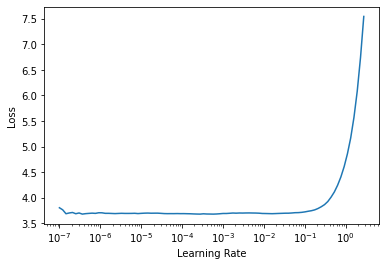

In [ ]:
learn.lr_find()

When we created our Learner the embeddings from the pre-trained AWD_LSTM model were merged with random embeddings added for words that weren't in the vocabulary. The pre-trained layers were also automatically frozen for us. Using fit_one_cycle with our Learner will train only the new random embeddings (i.e. words that are in our Twitter vocab but not the Wikipedia vocab) in the last layer of the neural network

In [ ]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.066971,2.903956,0.496153,18.246193,06:32


We can unfreeze the entire model, find a more suitable learning rate and train for a few more epochs to improve the accuracy further.

In [ ]:
learn.unfreeze()
# learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, 1e-3) #4 means 4 epoch

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.055696,2.884866,0.509043,17.901176,07:03
1,2.560153,2.481781,0.569966,11.962545,07:01
2,2.316329,2.333495,0.595523,10.313930,07:00
3,2.190758,2.309766,0.600834,10.072065,07:00


We can test our model by predicting the next word as below:

In [ ]:
TEXT = "I love"
N_WORDS = 45
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i love my daddy . He is a true doctor . He 's a doctors . Due to COVID-19 , he is no longer considered a doctor . Must be This is the conclusion of i know , we did
i love the fans . RT Have a great weekend ! The National Government has been working hard to limit the spread of the coronavirus , and we have been designed to This is the perfect way to manage


Let's save the model encoder so we can use it to fine-tune our classifier. The encoder is all of the model except for the final layer, which converts activations to probabilities of picking each token in the vocabulary. We want to keep the knowledge the model has learned about tweet language but we won't be using our classifier to predict the next word in a sentence, so we won't need the final layer any more.

In [ ]:
learn.save_encoder(os.path.join(path, 'finetuned_lm')) # save encoder
learn.save(os.path.join(path, 'finetuned_lm_0531')) # save model

# Training a sentiment classifier
To get the DataLoaders for our classifier let's use the DataBlock API this time, which is more customisable.

In [ ]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len = dls_lm.seq_len, vocab = dls_lm.vocab), CategoryBlock),
    # blocks = (TextBlock.from_df('text', seq_len = 72, vocab = vocab_list), CategoryBlock),
    get_x = ColReader('text'),
    get_y = ColReader('label'),
    splitter = RandomSplitter()
).dataloaders(df_clas, bs = 64)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
torch.save(dls_clas, os.path.join(path, 'dls_clas.pkl'))

To use the API, fastai needs the following:

blocks:
TextBlock: Our x variable will be text contained in a pandas DataFrame. We want to use the same sequence length and vocab as the language model DataLoaders so we can make use of our pre-trained model.
CategoryBlock: Our y variable will be a single-label category (negative, neutral or positive sentiment).
get_x, get_y: Get data for the model by reading the text and sentiment columns from the DataFrame.
splitter: We will use RandomSplitter() to randomly split the data into a training set (80% by default) and a validation set (20%).
dataloaders: Builds the DataLoaders using the DataBlock template we just defined, the df_clas DataFrame and a batch size of 64.

In [ ]:
dls_clas.show_batch(max_n=4)

,text,category
0,xxbos xxup ugg xxup want xxup to xxup go xxup to xxup xxunk xxup house xxup but i xxup ca nt xxup finna xxup be xxup bored xxup this xxup weekend xxrep 3 ! xxrep 3 u xxup xxunk xxup wanna xxup spend xxup da xxup nite xxup and xxup go xxup see xxup up xxup and xxup go xxup shopping,neutral
1,xxbos xxup my xxup car xxup is xxup almost xxup definately xxup going xxup to xxup be xxup written xxup off ! xxup the xxup garage xxup rang xxup and xxup said xxup the xxup work xxup will xxup cost 3k xxup and xxup its xxup up xxup to xxup the xxup insurance xxup co,neutral
2,"xxbos xxmaj yeah xxmaj it xxmaj good xxmaj but do nt xxmaj click xxmaj the xxmaj red x xxmaj because xxmaj it xxmaj shuts xxmaj it xxmaj down xxmaj but xxmaj other xxmaj then xxmaj that xxmaj its xxmaj good xxmaj and xxmaj when u minimize xxmaj it , xxmaj it xxmaj goes ..",positive
3,"xxbos d xxrep 4 u de , xxmaj tim said that they 're making a xxmaj red vs xxmaj blue animated series ! xxmaj it 'll be either on xxmaj adult xxmaj swim or xxup g4 . i hope xxup as , coz i do n't have xxup g4 !",neutral


Initialising the Learner is similar to before, but in this case we want a text_classifier_learner.

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Finally, we want to load the encoder from the language model we trained earlier, so our classifier uses pre-trained weights.

In [ ]:
learn = learn.load_encoder(os.path.join(path, 'finetuned_lm'))

## Fine-tuning the classifier
Now we can train the classifier using discriminative learning rates and gradual unfreezing, which has been found to give better results for this type of model. First let's freeze all but the last layer:

In [ ]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.843142,0.780375,0.653097,00:35


Now freeze all but the last two layers:

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.737293,0.644346,0.720307,00:37


Now all but the last three:

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.643461,0.584041,0.754151,00:38


Finally, let's unfreeze the entire model and train a bit more:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

In [ ]:
learn.save(os.path.join(path, 'twitter_classifier'))

Path('/content/drive/MyDrive/colab_data/twitter_classifier.pth')

In [ ]:
learn.predict("I hate")

('negative', tensor(0), tensor([0.9940, 0.0034, 0.0026]))

# Load model file

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).load(os.path.join(path, 'twitter_classifier'))

# Analysing the tweets
To carry out sentiment analysis on the vaccine tweets, we can add them to the DataLoaders as a test set:

In [ ]:
# load the model, do the prediction and save the output data
# learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).load(os.path.join(path, 'twitter_classifier'))
pred_dl = dls_clas.test_dl(covid_tweet['text'])
preds = learn.get_preds(dl=pred_dl)



Let's go ahead and check out the results.

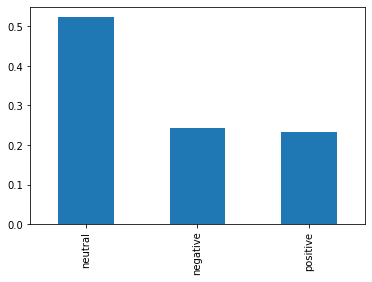

In [ ]:
# Get predicted sentiment
covid_tweet['label'] = preds[0].argmax(dim=-1)
covid_tweet['label'] = covid_tweet['label'].map({0:'negative', 1:'neutral', 2:'positive'})

# Save to csv
covid_tweet.to_csv(os.path.join(path, 'covid_tweet_sentiment.csv'))

# Plot sentiment value counts
covid_tweet['label'].value_counts(normalize=True).plot.bar();